## Objective 
- <b>My aim throughout this process has been to look at what is common to plays involving concussions in the NGS data and what you can perceive in the videos. From that analysis I choose to propose rule changes that would likely affect the outcome of the punt plays by negating the possibility of certain events or to have rules that would hopefully create a behavioral change in how players partake in the punt play.</b>
- This analysis is for getting an idea of what's happening in the punts that result in a concussion. We will look at who is concussed and the primary partner of the concussed player. We'll also look at subjective labeling of the concussion plays that were deduced from the videos of the plays.
- **Take an empirical approach**

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image, display

## VIDEO SECTION
#### VIDEO REVIEW
- <b>Player Punt Data</b>: Player level data that specifies the traditional football position for each player. Each player is identified using his GSISID.
- <b>Play Player Role Data</b>: Play and player level data that specifies a punt specific player role. This dataset will specify each player that played in each play. A player’s role in a play is uniquely defined by the Gamekey PlayID and GSISID.
- <b>Video Review</b>: Injury level data that provides a detailed description of the concussion-producing event. Video Review data are only available in cases in which the injury play can be identified. Each video review case can be identified using a combination of GameKey, PlayID, and GSISID. A brief narrative of the play events is provided.
- <b>Primary Impact Type</b>: gives source of trauma; Unclear means exactly what you think
- <b>Primary_Partner_GSISID</b>: usual suspects?
    - If both the player and partner are concuseed, then each player will be listed as a player
- <b>37 Concussions</b> Identified out of 6681 punts = 0.5538%

In [65]:
# Load in concussion data deduced from video review of the play
video_review_df = pd.read_csv('data/video_review.csv')
print(video_review_df.shape)
video_review_df.head(1)

(37, 10)


,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
0,2016,5,3129,31057,Tackling,No,Helmet-to-body,32482,Tackled,No


In [66]:
# Load in player related data
player_df = pd.read_csv('data/player_punt_data.csv')
play_player_role_df = pd.read_csv('data/play_player_role_data.csv')

# Combine Relevant Player Information, Position, Role, Number
master_player_df = pd.merge(player_df, play_player_role_df,
                          how='inner',
                          on=['GSISID']).drop(columns=['Season_Year'])
master_player_df.head()

,GSISID,Number,Position,GameKey,PlayID,Role
0,32069,36,SS,23,2255,PPL
1,32069,36,SS,23,884,PRW
2,32069,36,SS,23,1157,PRW
3,32069,36,SS,23,848,PRW
4,32069,36,SS,23,3065,PPL


In [67]:
# Check summary counts to see if any are needed
print(video_review_df['Player_Activity_Derived'].value_counts())
print('---')
print(video_review_df['Turnover_Related'].value_counts())
print('---')
print(video_review_df['Primary_Impact_Type'].value_counts())
print('---')
print(video_review_df['Primary_Partner_Activity_Derived'].value_counts())
print('---')
print(video_review_df['Friendly_Fire'].value_counts())

where_condition = ((video_review_df['Primary_Partner_GSISID'] == 'Unclear') |
                   (video_review_df['Primary_Partner_GSISID'].isna()))
video_review_df[where_condition]

Tackling    13
Blocked     10
Blocking     8
Tackled      6
Name: Player_Activity_Derived, dtype: int64
---
No    37
Name: Turnover_Related, dtype: int64
---
Helmet-to-body      17
Helmet-to-helmet    17
Helmet-to-ground     2
Unclear              1
Name: Primary_Impact_Type, dtype: int64
---
Blocked     10
Tackling    10
Tackled      8
Blocking     6
Unclear      1
Name: Primary_Partner_Activity_Derived, dtype: int64
---
No         28
Yes         6
Unclear     1
Name: Friendly_Fire, dtype: int64


,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
9,2016,218,3468,28987,Blocked,No,Helmet-to-ground,NaN,NaN,NaN
26,2017,414,1262,33941,Tackling,No,Helmet-to-ground,NaN,NaN,NaN
29,2017,506,1988,27060,Tackled,No,Helmet-to-helmet,NaN,Tackling,No
33,2017,585,733,30384,Blocked,No,Unclear,Unclear,Unclear,Unclear


### Observations
- So we know things involve tackling and blocking (you need contact of some sort to have a concussion)
- We see no plays resulted in a turnover.
- We can see majority of concussions are related to a helmet hitting some other mass minus the one 'unclear' instance
- Majority of concussions are not a result of friendly fire
- There are 4 plays that have no designated primary_partner: two were helmet-to-ground, 1 was unclear, and 1 was helmet to helmet (H2H).
    - If you review those two latter videos, the 'unclear' designation was a clear helmet to the back of the head of #44 by Houston Player #55/56 (not sure of number; could probably verify with GSISID from NGS data for the play) and for the H2H you can see Dolphins #34 make a diving head tackle on Baltimore #21.
        - This information you can deduce by looking at the play video later in the analysis. <b>I MIGHT REPLACE THESE NAN AND UNCLEAR LATER WITH THE CORRECT DATA IF IT SEEMS USEFUL FOR MY OWN ANALYSIS</b>

In [68]:
# Now that we have a descriptive idea of what's going on, I'm gonna just drop these columns
# and also clear up the unclear designation and convert it to NaN
droppers = ['Player_Activity_Derived', 'Turnover_Related', 'Primary_Partner_Activity_Derived', 
            'Friendly_Fire', 'Season_Year']
video_review_df.drop(columns=droppers, inplace=True)

# Remove 'Unclear' designation
video_review_df.loc[33, 'Primary_Partner_GSISID'] = 'NaN'

#### VIDEO FOOTAGE

In [69]:
'''Control Video Footage'''
video_footage_control_df = pd.read_csv('data/video_footage-control.csv')
print(video_footage_control_df.shape)
video_footage_control_df.tail(1)

(37, 10)


,season,Season_Type,Week,Home_team,Visit_Team,Qtr,PlayDescription,gamekey,playid,Preview Link
36,2017,Reg,2,New Orleans Saints,New England Patriots,3,"(7:42) R.Allen punts 27 yards to NO 29, Center...",421,2870,http://a.video.nfl.com//films/vodzilla/153628/...


In [70]:
# # Use for printing out video links
# for i in range(len(video_footage_control_df)):
#     print(video_footage_control_df.loc[i, 'Preview Link'])

- Use the control video footage if you need to improve your understanding of how a punt play usually runs

In [71]:
'''Concussion Video Footage'''
video_footage_injury_df = pd.read_csv('data/video_footage-injury.csv')
print(video_footage_injury_df.shape)
video_footage_injury_df.head(1)

(37, 10)


,season,Type,Week,Home_team,Visit_Team,Qtr,PlayDescription,gamekey,playid,PREVIEW LINK (5000K)
0,2016,Pre,2,Chicago Bears,Denver Broncos,3,(3:44) (Punt formation) P.O'Donnell punts 58 y...,5,3129,http://a.video.nfl.com//films/vodzilla/153233/...


In [72]:
# # Injury Video Links; search for player who is injured; watch the film, be the film....
# for i in range(len(video_footage_injury_df)):
#     print(i, video_footage_injury_df['PREVIEW LINK (5000K)'][i])

In [73]:
# Preprocess to allow for easier joins
rename_columns = {'gamekey': 'GameKey', 'playid': 'PlayID', 'season': 'Season_Year'}
video_footage_injury_df.rename(columns=rename_columns, inplace=True)

# Combine Video Review and Video Injury DataFrames to have the injured player and partner player data
injury_play = pd.merge(video_review_df, video_footage_injury_df, 
                       how='inner', 
                       on=['GameKey', 'PlayID'])

# Lets Drop Some More Data I consider uncritical for getting a feel for the data
droppers = ['Season_Year', 'Type', 'Week', 'Home_team', 'Visit_Team', 'Qtr']
injury_play.drop(columns=droppers, inplace=True)

injury_play.head(1)

,GameKey,PlayID,GSISID,Primary_Impact_Type,Primary_Partner_GSISID,PlayDescription,PREVIEW LINK (5000K)
0,5,3129,31057,Helmet-to-body,32482,(3:44) (Punt formation) P.O'Donnell punts 58 y...,http://a.video.nfl.com//films/vodzilla/153233/...


In [74]:
# Join Info (their jersey number, position, role) on the concussed player
injury_play = pd.merge(injury_play, master_player_df,
                           how='inner',
                           on=['GSISID', 'GameKey', 'PlayID'])

print('Shape:', injury_play.shape)
injury_play.head(1)

Shape: (58, 10)


,GameKey,PlayID,GSISID,Primary_Impact_Type,Primary_Partner_GSISID,PlayDescription,PREVIEW LINK (5000K),Number,Position,Role
0,5,3129,31057,Helmet-to-body,32482,(3:44) (Punt formation) P.O'Donnell punts 58 y...,http://a.video.nfl.com//films/vodzilla/153233/...,25,RB,PLW


- I get the concussed player's information to identify their jersey number in the video. With potentially multiple jersey numbers associated with a player, this was needed information to focus on what events led up to the concussion. I watched the film and cross referenced plays where it was unclear as to the players number with game recaps (googled) to identify the concussed players number.

In [75]:
# Drop Certain Rows After Identifying Concussed Players Jersey Number from video
drop_rows = [1, 7, 17, 20, 23, 26, 27, 28, 29, 32, 33, 36, 38, 39, 45, 46, 47, 50, 52, 55, 57]
injury_play.drop(labels=drop_rows, inplace=True)
injury_play.reset_index(drop=True, inplace=True)

# Convert Primary_Partner_GSISID from str to float
injury_play['Primary_Partner_GSISID'] = injury_play['Primary_Partner_GSISID'].astype('float')
injury_play.shape

(37, 10)

- So we're back to our good ole 37 concussions

## NGS DATA SECTION: 

### CONCUSSION PLAY ANALYSIS
- <b>Next Gen Stats</b>: player level data that describes the movement of each player during a play. NGS data is processed by BIOCORE to produce relevant speed and direction data. The NGS data is identified using GameKey, PlayID, and GSISID. Player data for each play is provided as a function of time (Time) for the duration of the play.
- Players are recorded at every <b>10th of a second or 100 milliseconds</b>
- Field dimensions: 120 yards by 53.3 yards
- Speed can be calculated with Time and dis
- <b>Event</b> records essentially game states ('line_set', 'punt', 'punt_received', etc.)
- I will load in the NGS data that are associated with these particular plays, this data is created in a separate notebook (**LINK TO SEPARATE NOTEBOOK**)

In [76]:
# Load in NGS data, player role data, and play info
ngs_concussion = pd.read_csv('data/NGS-concussion.csv')
play_player_role_df = pd.read_csv('data/play_player_role_data.csv')
play_df = pd.read_csv('data/play_information.csv')

# Merge datasets
ngs_concussion = pd.merge(ngs_concussion, play_player_role_df,
                  how="inner",
                  on=['GameKey', 'PlayID', 'GSISID'])

ngs_concussion = pd.merge(ngs_concussion, play_df,
                  how="inner",
                  on=['GameKey', 'PlayID'])

# Cleanup
keepers = ['GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'dis', 'Event', 'Role', 'PlayDescription']
ngs_concussion = ngs_concussion[keepers]
ngs_ids = ngs_concussion.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
print('Number of unique plays in NGS dataset:', ngs_ids.shape[0])
ngs_concussion.head()

Number of unique plays in NGS dataset: 37


,GameKey,PlayID,GSISID,Time,x,y,dis,Event,Role,PlayDescription
0,5,3129,31130.0,2016-08-12 02:07:26.300,80.540001,25.969999,0.06,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
1,5,3129,31130.0,2016-08-12 02:07:26.400,80.559998,25.920000,0.05,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
2,5,3129,31130.0,2016-08-12 02:07:26.500,80.580002,25.879999,0.04,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
3,5,3129,31130.0,2016-08-12 02:07:26.600,80.589996,25.850000,0.03,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
4,5,3129,31130.0,2016-08-12 02:07:26.700,80.580002,25.840000,0.01,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...


### Reasoning for analyzing speeds
- Again this notebook is more to explore parts of plays involving concussions. I wanted to understand what speeds the concussed player and the partner player were running at throughout the play. I mostly wanted to see severity of impact. I plot their routes with their corresponding speeds. I do not label each player because it's only used as reference to what's in the actual videos. I do not evaluate 'o' and 'dir' variables because previous analyses didn't seem to give any useful information to me. Maybe it helps if you're a biomechanical engineer.

In [77]:
from IPython.display import display, HTML

def make_html(game_key, play_id):
    return '<img src="{}" style="display:inline;margin:1px"/>'\
    .format('gifs/' + str(game_key) + '_' + str(play_id) + '.gif')

GameKey: 5 PlayID: 3129
Play Description: (3:44) (Punt formation) P.O'Donnell punts 58 yards to DEN 11, Center-P.Scales. B.Addison to DEN 25 for 14 yards (K.Carey). PENALTY on DEN-S.Sulleyman, Illegal Block Above the Waist, 10 yards, enforced at DEN 25.
Primary Impact Type: Helmet-to-body
Concussed: 31057 Role: PLW
Partner: 32482.0


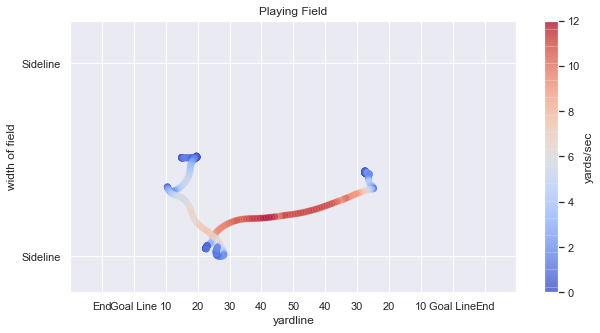

---
GameKey: 21 PlayID: 2587
Play Description: (5:52) (Punt formation) K.Redfern punts 36 yards to TEN 9, Center-J.Jansen, downed by CAR-B.Wegher. PENALTY on TEN-M.Huff, Illegal Blindside Block, 5 yards, enforced at TEN 9.
Primary Impact Type: Helmet-to-helmet
Concussed: 29343 Role: GL
Partner: 31059.0


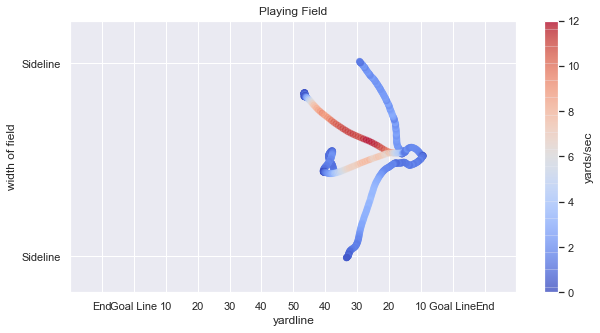

---
GameKey: 29 PlayID: 538
Play Description: (4:46) L.Edwards punts 51 yards to WAS 27, Center-T.Purdum. J.Crowder MUFFS catch, touched at WAS 27, recovered by WAS-Q.Dunbar at WAS 11. Q.Dunbar to WAS 11 for no gain (M.Williams).
Primary Impact Type: Helmet-to-body
Concussed: 31023 Role: GR
Partner: 31941.0


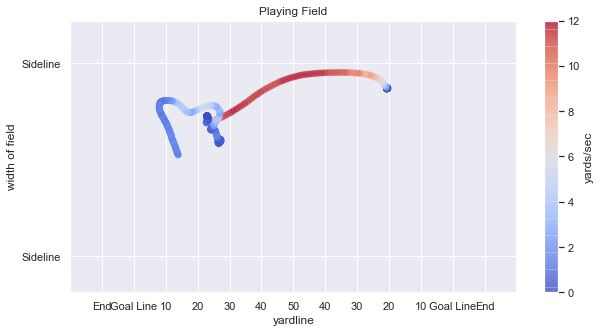

---
GameKey: 45 PlayID: 1212
Play Description: (8:29) B.Wing punts 44 yards to NYJ 10, Center-T.Ott. J.Ross to NYJ 38 for 28 yards (O.Darkwa; B.Goodson).
Primary Impact Type: Helmet-to-body
Concussed: 33121 Role: PRT
Partner: 28249.0


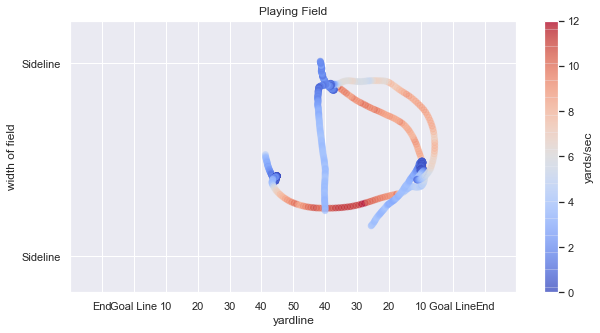

---
GameKey: 54 PlayID: 1045
Play Description: (9:57) J.Berry punts 45 yards to CAR 31, Center-G.Warren. D.Byrd to CAR 46 for 15 yards (S.Davis).
Primary Impact Type: Helmet-to-body
Concussed: 32444 Role: PRT
Partner: 31756.0


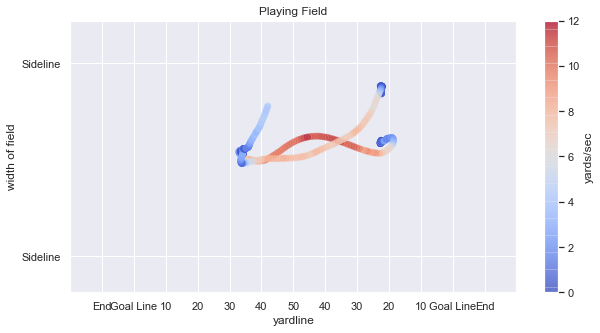

---
GameKey: 60 PlayID: 905
Play Description: (:38) C.Schmidt punts 46 yards to DET 8, Center-G.Sanborn. J.Billingsley to DET 13 for 5 yards (M.Lawson). PENALTY on DET-D.Walls, Illegal Block Above the Waist, 3 yards, enforced at DET 7.
Primary Impact Type: Helmet-to-helmet
Concussed: 30786 Role: PRW
Partner: 29815.0


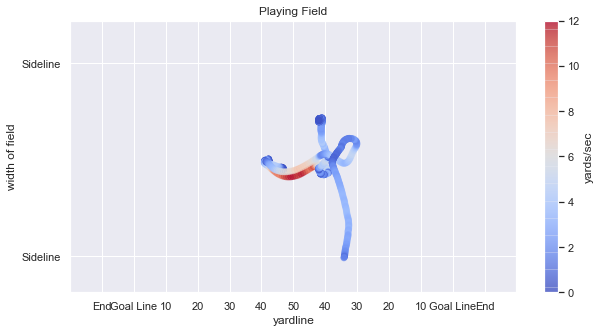

---
GameKey: 144 PlayID: 2342
Play Description: (13:21) C.Schmidt punts 54 yards to SF 19, Center-G.Sanborn. J.Kerley to SF 31 for 12 yards (M.Gillislee).
Primary Impact Type: Helmet-to-body
Concussed: 32410 Role: VR
Partner: 23259.0


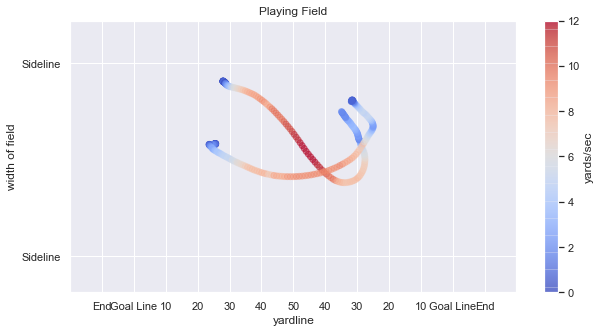

---
GameKey: 149 PlayID: 3663
Play Description: (1:07) T.Morstead punts 54 yards to CAR 39, Center-J.Drescher. T.Ginn to 50 for 11 yards (D.Lasco).
Primary Impact Type: Helmet-to-body
Concussed: 28128 Role: PFB
Partner: 29629.0


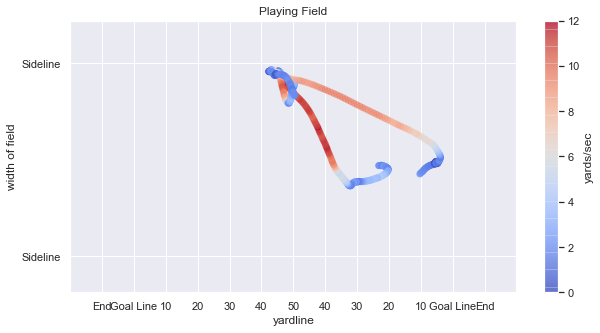

---
GameKey: 189 PlayID: 3509
Play Description: (6:46) D.Colquitt punts 54 yards to JAX 31, Center-J.Winchester. B.Walters to JAX 39 for 8 yards (F.Zombo).
Primary Impact Type: Helmet-to-helmet
Concussed: 27595 Role: PR
Partner: 31950.0


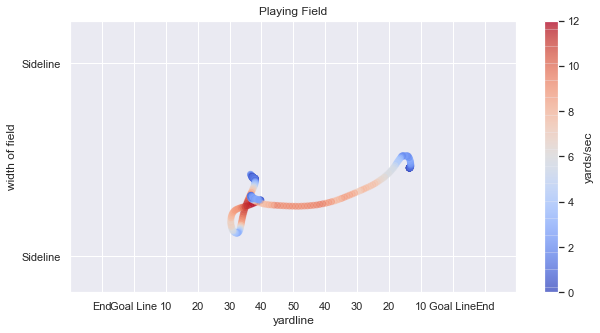

---
GameKey: 218 PlayID: 3468
Play Description: (8:03) (Punt formation) B.Kern punts 46 yards to IND 37, Center-B.Brinkley. C.Rogers to IND 39 for 2 yards (W.Woodyard).
Primary Impact Type: Helmet-to-ground
Concussed: 28987 Role: PLG
Partner: nan


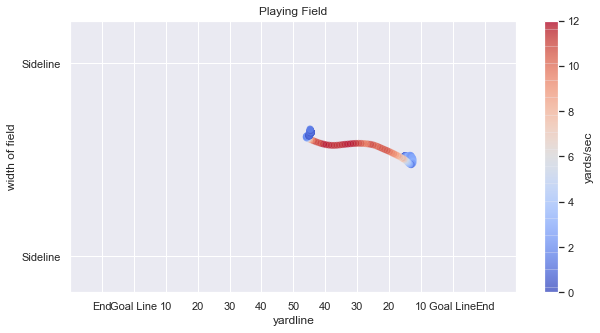

---
GameKey: 231 PlayID: 1976
Play Description: (1:15) (Punt formation) K.Huber punts 58 yards to BLT 14, Center-T.Ott. D.Hester MUFFS catch, and recovers at BLT 12. D.Hester pushed ob at BLT 27 for 15 yards (N.Vigil). CIN-C.Brown was injured during the play.
Primary Impact Type: Helmet-to-helmet
Concussed: 32214 Role: PLG
Partner: 32807.0


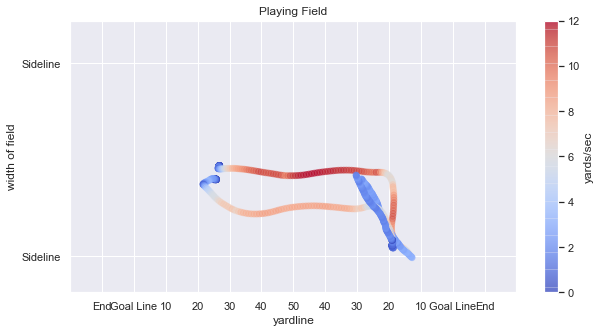

---
GameKey: 234 PlayID: 3278
Play Description: (13:00) (Punt formation) B.Wing punts 43 yards to CLV 5, Center-Z.DeOssie, downed by NYG-D.Harris. NYG-M.Herzlich was injured during the play. His return is Questionable.
Primary Impact Type: Helmet-to-body
Concussed: 28620 Role: PRG
Partner: 27860.0


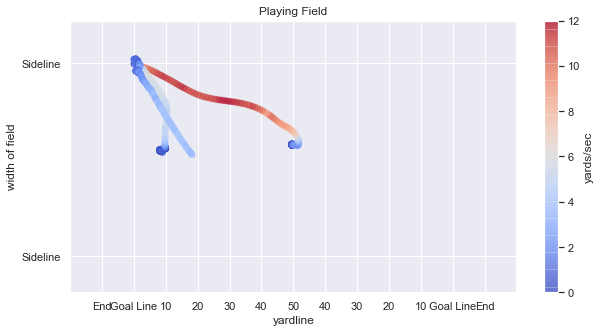

---
GameKey: 266 PlayID: 2902
Play Description: (11:38) T.Way punts 45 yards to PHI 25, Center-N.Sundberg, downed by WAS. PHI-D.Sproles was injured during the play. PENALTY on WAS-D.Everett, Interference with Opportunity to Catch, 15 yards, enforced at PHI 25.
Primary Impact Type: Helmet-to-body
Concussed: 23564 Role: PR
Partner: 31844.0


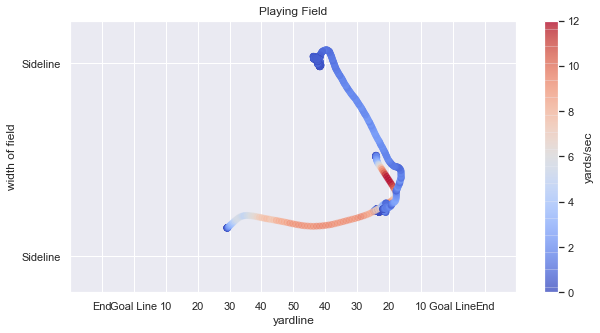

---
GameKey: 274 PlayID: 3609
Play Description: (5:22) (Punt formation) J.Ryan up the middle to LA 47 for 26 yards. FUMBLES, recovered by SEA-N.Thorpe at LA 40. SEA-J.Ryan was injured during the play. Los Angeles challenged the loose ball recovery ruling, and the play was Upheld. The ruling on the field stands. (Timeout #2.)
Primary Impact Type: Helmet-to-helmet
Concussed: 23742 Role: P
Partner: 31785.0


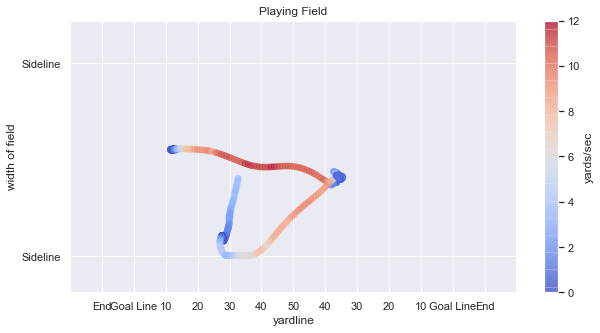

---
GameKey: 280 PlayID: 2918
Play Description: (3:36) B.Nortman punts 49 yards to HST 30, Center-C.Tinker, fair catch by W.Fuller.
Primary Impact Type: Helmet-to-body
Concussed: 32120 Role: PLW
Partner: 32725.0


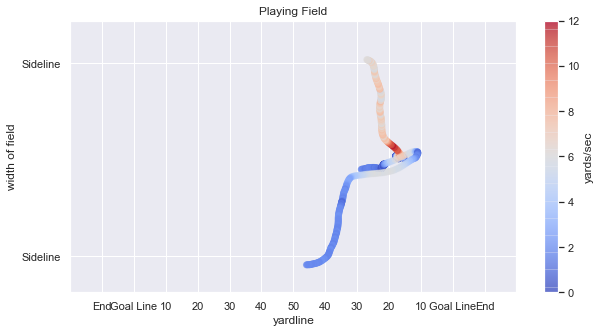

---
GameKey: 280 PlayID: 3746
Play Description: (5:57) B.Nortman punts 41 yards to HST 44, Center-C.Tinker. W.Fuller to HST 48 for 4 yards (A.Benn).
Primary Impact Type: Helmet-to-helmet
Concussed: 27654 Role: GL
Partner: 33127.0


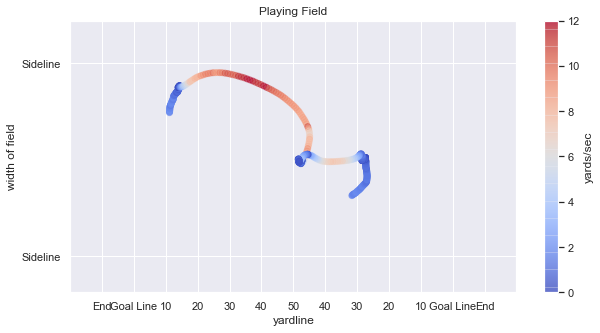

---
GameKey: 281 PlayID: 1526
Play Description: (1:52) B.Kern punts 38 yards to TEN 48, Center-B.Brinkley. T.Hill to TEN 45 for 3 yards (N.Palmer; A.Andrews).
Primary Impact Type: Helmet-to-body
Concussed: 28987 Role: PLG
Partner: 30789.0


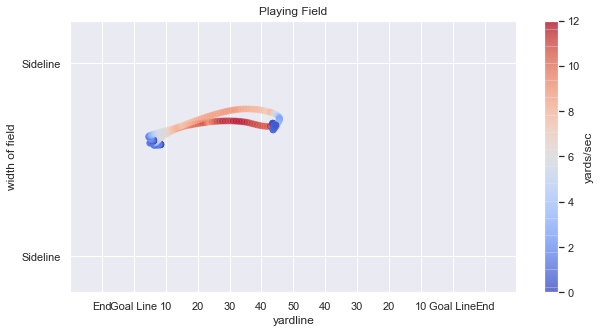

---
GameKey: 289 PlayID: 2341
Play Description: (12:41) T.Way punts 51 yards to CAR 23, Center-N.Sundberg. T.Ginn pushed ob at CAR 42 for 19 yards (T.Garvin). WAS-Q.Dunbar was injured during the play. He is Out. 47- Dunbar is being evaluated for a concussion
Primary Impact Type: Helmet-to-helmet
Concussed: 32007 Role: GL
Partner: 32998.0


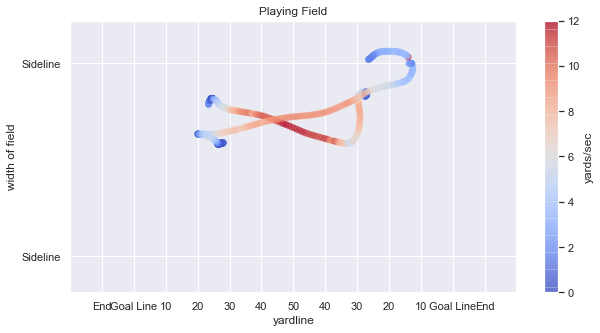

---
GameKey: 296 PlayID: 2667
Play Description: (6:11) B.Kern punts 43 yards to JAX 23, Center-B.Brinkley. B.Walters to JAX 23 for no gain (K.Reed; L.Sims).
Primary Impact Type: Helmet-to-helmet
Concussed: 32783 Role: GL
Partner: 32810.0


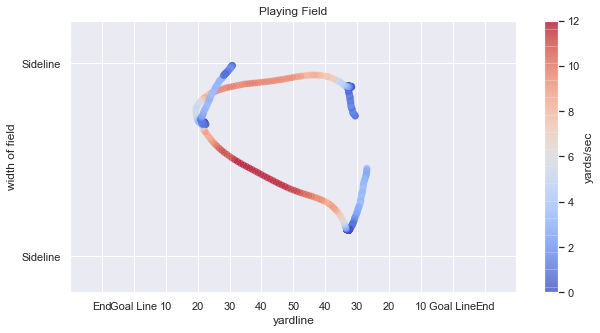

---
GameKey: 357 PlayID: 3630
Play Description: (13:22) (Punt formation) M.Haack punts 52 yards to BLT 25, Center-W.Chapman. B.Rainey to BLT 34 for 9 yards (D.Morgan). MIA-C.Pantale was injured during the play. His return is Questionable.
Primary Impact Type: Helmet-to-body
Concussed: 30171 Role: PRG
Partner: 29384.0


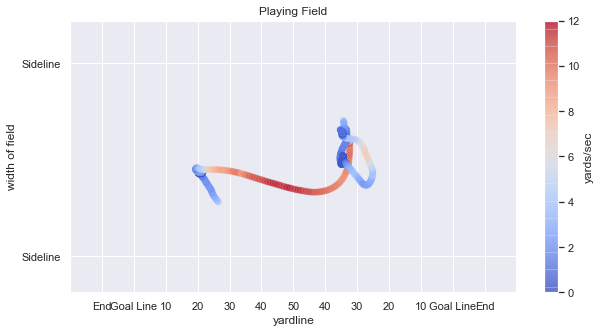

---
GameKey: 364 PlayID: 2489
Play Description: (11:50) J.Vogel punts 44 yards to WAS 32, Center-D.Hart. K.Fuller to WAS 37 for 5 yards (K.King). PENALTY on WAS-J.Harvey-Clemons, Offensive Holding, 10 yards, enforced at WAS 31.
Primary Impact Type: Helmet-to-helmet
Concussed: 31313 Role: PLT
Partner: 32851.0


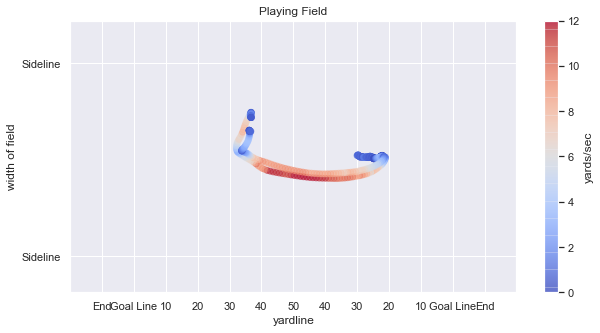

---
GameKey: 364 PlayID: 2764
Play Description: (8:23) J.Vogel punts 43 yards to WAS 48, Center-D.Hart. K.Fuller to GB 40 for 12 yards (J.Hawkins).
Primary Impact Type: Helmet-to-helmet
Concussed: 32323 Role: PLG
Partner: 31930.0


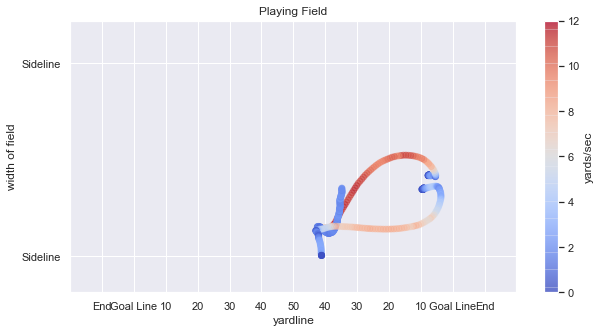

---
GameKey: 384 PlayID: 183
Play Description: (12:29) B.Nortman punts 40 yards to ATL 25, Center-M.Overton. J.Hardy to ATL 32 for 7 yards (B.Brown). JAX-J.Harper was injured during the play. PENALTY on ATL-J.Keyes, Offensive Holding, 10 yards, enforced at ATL 25.
Primary Impact Type: Helmet-to-body
Concussed: 33813 Role: PPR
Partner: 33841.0


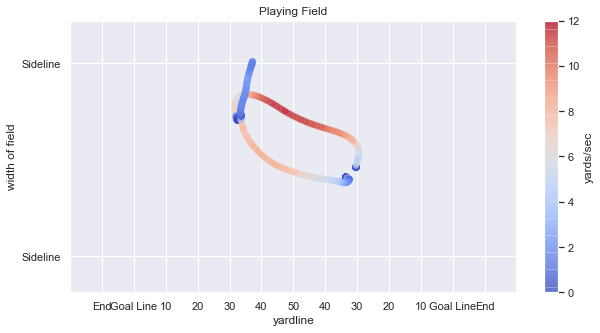

---
GameKey: 392 PlayID: 1088
Play Description: (9:57) B.Kern punts 61 yards to KC 24, Center-R.DiSalvo. J.Chesson for 76 yards, TOUCHDOWN. TEN-R.DiSalvo was injured during the play.
Primary Impact Type: Helmet-to-body
Concussed: 32615 Role: PLS
Partner: 31999.0


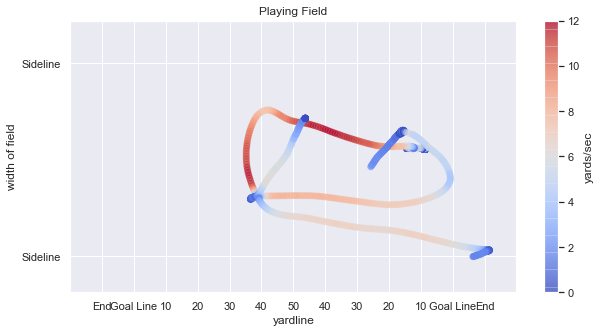

---
GameKey: 397 PlayID: 1526
Play Description: (2:10) T.Baker punts 41 yards to SF 11, Center-M.Windt. D.Carter to SF 14 for 3 yards (J.Perry; D.Brown).
Primary Impact Type: Helmet-to-helmet
Concussed: 32894 Role: PLT
Partner: 31763.0


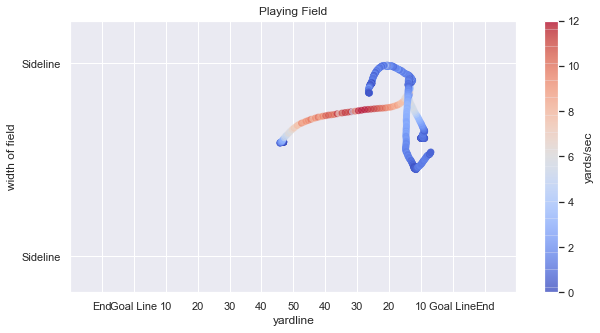

---
GameKey: 399 PlayID: 3312
Play Description: (3:22) D.Colquitt punts 36 yards to KC 47, Center-J.Winchester. D.Amendola to KC 44 for 3 yards (T.Smith). PENALTY on NE-B.Bolden, Running Into the Kicker, 5 yards, enforced at KC 11 - No Play.
Primary Impact Type: Helmet-to-body
Concussed: 26035 Role: PR
Partner: 27442.0


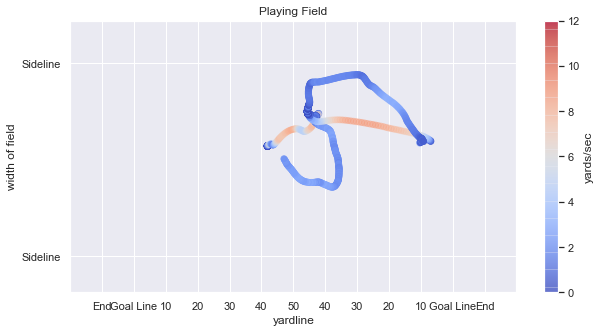

---
GameKey: 414 PlayID: 1262
Play Description: (10:20) D.Kaser punts 59 yards to DEN 13, Center-M.Windt. I.McKenzie ran ob at DEN 44 for 31 yards.
Primary Impact Type: Helmet-to-ground
Concussed: 33941 Role: PLW
Partner: nan


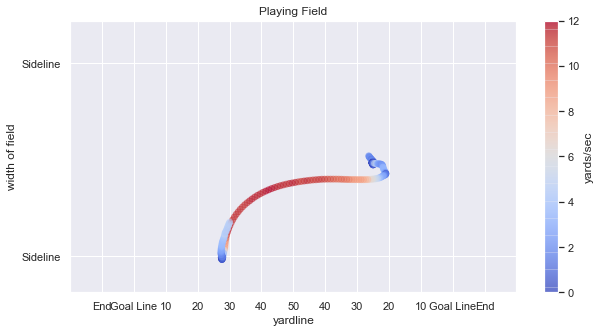

---
GameKey: 448 PlayID: 2792
Play Description: (4:19) (Punt formation) M.Haack punts 42 yards to NO 30, Center-J.Denney. T.Ginn ran ob at NO 39 for 9 yards (J.Denney).
Primary Impact Type: Helmet-to-body
Concussed: 33838 Role: PDR1
Partner: 31317.0


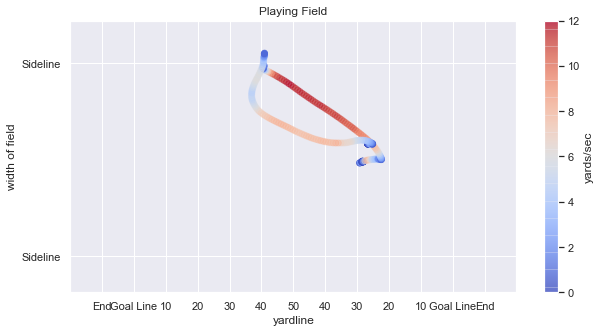

---
GameKey: 473 PlayID: 2072
Play Description: (9:49) M.King punts 62 yards to BLT 15, Center-J.Condo. M.Campanaro to BLT 24 for 9 yards (J.Condo, J.Cowser).
Primary Impact Type: Helmet-to-body
Concussed: 29492 Role: PRG
Partner: 33445.0


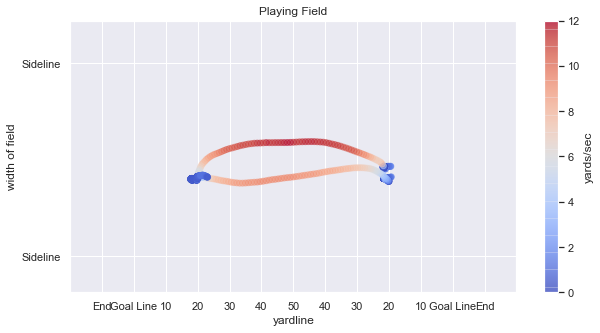

---
GameKey: 506 PlayID: 1988
Play Description: (1:12) (Punt formation) M.Haack punts 41 yards to BLT 29, Center-J.Denney. L.Webb to BLT 29 for no gain.
Primary Impact Type: Helmet-to-helmet
Concussed: 27060 Role: PR
Partner: nan


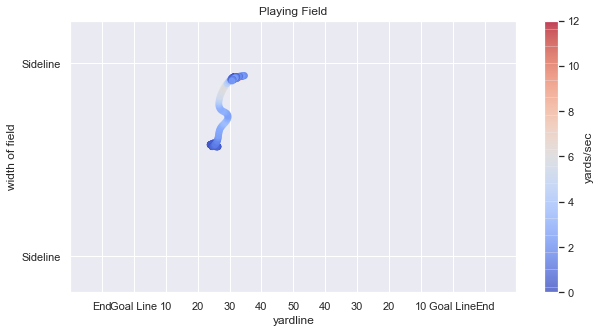

---
GameKey: 553 PlayID: 1683
Play Description: (1:10) B.Wing punts 37 yards to KC 29, Center-Z.DeOssie. T.Hill pushed ob at KC 49 for 20 yards (N.Berhe). Penalty on KC-F.Zombo, Offensive Holding, declined. PENALTY on KC-T.Smith, Unnecessary Roughness, 15 yards, enforced at KC 33. Officially, a return for 4 yards.
Primary Impact Type: Helmet-to-helmet
Concussed: 32820 Role: PDL2
Partner: 25503.0


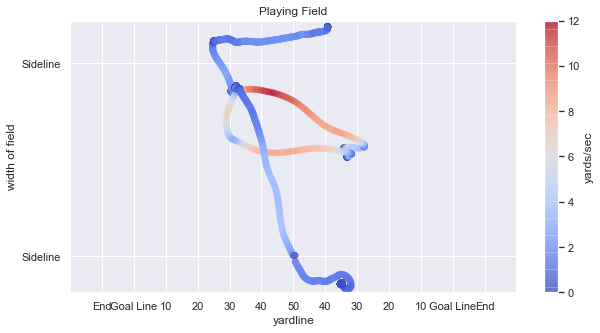

---
GameKey: 567 PlayID: 1407
Play Description: (7:18) M.Palardy punts 53 yards to NYJ 17, Center-J.Jansen. J.Natson to NYJ 10 for -7 yards (S.Thompson).
Primary Impact Type: Helmet-to-helmet
Concussed: 32403 Role: PLL
Partner: 32891.0


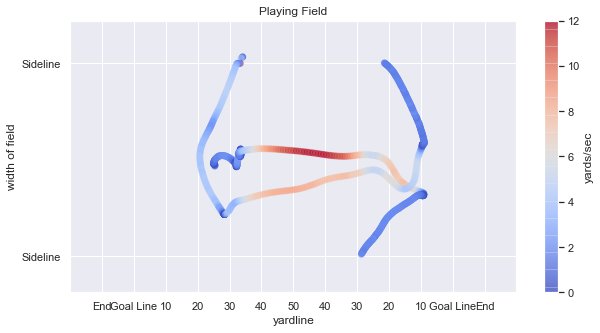

---
GameKey: 585 PlayID: 2208
Play Description: (13:36) (Punt formation) B.Kern punts 55 yards to HST 18, Center-B.Brinkley. B.Miller ran ob at HST 26 for 8 yards (E.Weems).
Primary Impact Type: Helmet-to-helmet
Concussed: 33069 Role: PR
Partner: 24535.0


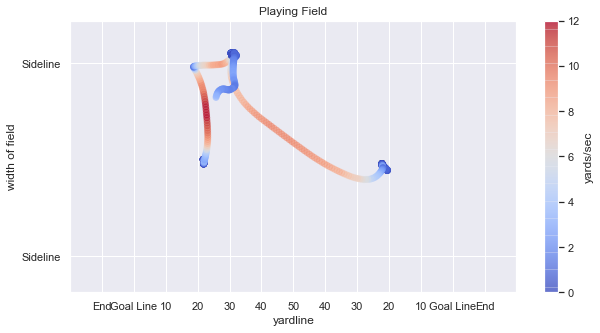

---
GameKey: 585 PlayID: 733
Play Description: (2:57) (Punt formation) S.Lechler punts 48 yards to TEN 16, Center-J.Weeks. A.Jackson pushed ob at TEN 32 for 16 yards (J.Jenkins). PENALTY on TEN-J.Brown, Illegal Block Above the Waist, 10 yards, enforced at TEN 32.
Primary Impact Type: Unclear
Concussed: 30384 Role: PRW
Partner: nan


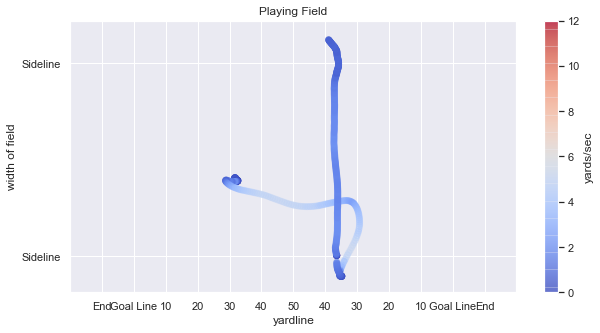

---
GameKey: 601 PlayID: 602
Play Description: (5:56) L.Edwards punts 47 yards to DEN 37, Center-T.Hennessy. J.Taylor to DEN 49 for 12 yards (J.Burris; T.Hennessy). NYJ-T.Hennessy was injured during the play. His return is Probable.
Primary Impact Type: Helmet-to-helmet
Concussed: 33260 Role: PLS
Partner: 31697.0


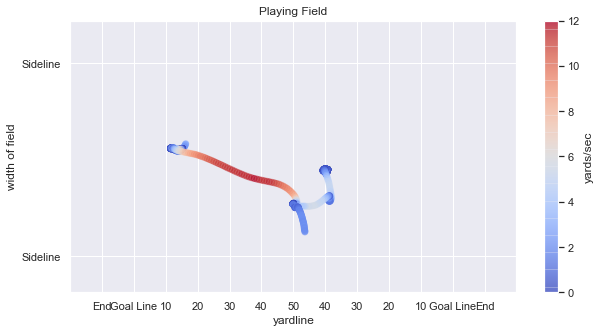

---
GameKey: 607 PlayID: 978
Play Description: (14:11) (Punt formation) R.Sanchez punts 27 yards to DEN 11, Center-L.Rhodes, fair catch by J.Taylor. IND-B.Williams was injured during the play. He is Out. PENALTY on IND-C.Milton, Fair Catch Interference, 15 yards, enforced at DEN 11.
Primary Impact Type: Helmet-to-helmet
Concussed: 29793 Role: PLW
Partner: 32114.0


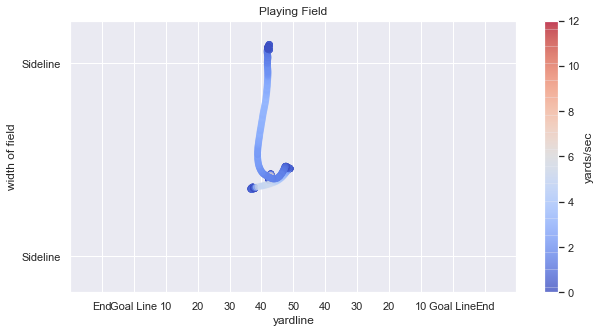

---
GameKey: 618 PlayID: 2792
Play Description: (5:39) J.Ryan punts 61 yards to LA 13, Center-T.Ott. P.Cooper to LA 22 for 9 yards (B.McDougald; D.Alexander).
Primary Impact Type: Helmet-to-body
Concussed: 31950 Role: PRG
Partner: 32677.0


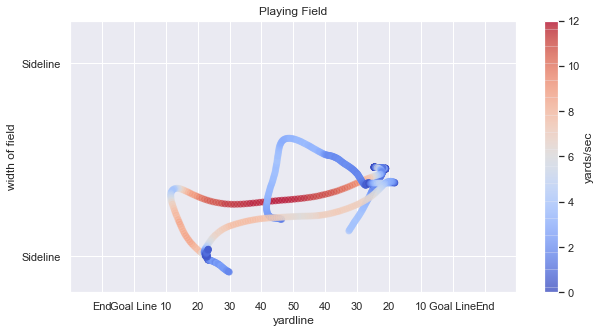

---


In [78]:
'''Map Routes of concussed player and partner player and give approximate speeds throughout their route'''

for i in range(len(injury_play)):
    # Get necessary values for query of NGS data
    game_key = injury_play.loc[i, 'GameKey']
    play_id = injury_play.loc[i, 'PlayID']
    concussed_id = injury_play.loc[i, 'GSISID']
    partner_id = injury_play.loc[i, 'Primary_Partner_GSISID']
    print('GameKey:', game_key, 'PlayID:', play_id)
    print('Play Description:', injury_play.loc[i,'PlayDescription'])
    print('Primary Impact Type:', injury_play.loc[i, 'Primary_Impact_Type'])
    print('Concussed:', concussed_id, 'Role:', injury_play.loc[i, 'Role'])
    print('Partner:', partner_id)
    # Visualizing play with .gif file
    display(HTML(''.join(make_html(game_key, play_id))))
    
    # Concussed player
    where_condition = (
        (ngs_concussion['GameKey'] == game_key)&\
        (ngs_concussion['PlayID'] == play_id) &\
        (ngs_concussion['GSISID'] == concussed_id))
    concussion = ngs_concussion[where_condition].copy()
    # Reorder by Time and reset index
    concussion.sort_values(by=['Time'], inplace=True)
    concussion.reset_index(drop=True, inplace=True)
    
    # Partner player
    where_condition = (
        (ngs_concussion['GameKey'] == game_key)&\
        (ngs_concussion['PlayID'] == play_id) &\
        (ngs_concussion['GSISID'] == partner_id))
    partner = ngs_concussion[where_condition].copy()
    partner.sort_values(by=['Time'], inplace=True)
    partner.reset_index(drop=True, inplace=True) 

    # Variables for Mapping
    concussion_x = concussion['x']
    concussion_y = concussion['y']
    partner_x = partner['x']
    partner_y = partner['y']
    speed1 = concussion['dis'] / 0.1
    speed2 = partner['dis'] / 0.1
    
    # Mapping of play
    sns.set()
    plt.figure(figsize=(10,5))
    cmap = plt.get_cmap('coolwarm')
    plt.scatter(concussion_x, concussion_y, c=speed1, cmap=cmap, alpha=0.5)
    if partner_id != 'NaN':
        plt.scatter(partner_x, partner_y, c=speed2, cmap=cmap, alpha=0.5)
    plt.clim(0, 12)
    plt.colorbar(label='yards/sec')
    # Normal length of field is 120 yards
    plt.xlim(-10, 130)
    plt.xticks(np.arange(0, 130, step=10),
               ['End', 'Goal Line', '10', '20', '30', '40', '50', '40', '30', '20', '10', 'Goal Line', 'End'])
    # Normal width is 53.3 yards
    plt.ylim(-10, 65)
    plt.yticks(np.arange(0, 65, 53.3), ['Sideline', 'Sideline'])
    plt.title('Playing Field')
    plt.xlabel('yardline')
    plt.ylabel('width of field')
    plt.show()
    print('---')

- All mentions of a play are in this format: (GameKey, PlayId)
- Video link for play <b>(281, 1526)</b> is incorrect.
    - Play can be identified from times (13:52 to 14:03) of video (https://www.youtube.com/watch?v=NsBDbLWcLyM)
    - Looks like an illegal block above the waist (https://operations.nfl.com/the-rules/nfl-video-rulebook/illegal-block-above-the-waist/) that was not called
- Note: fastest times for 40 yard dash range from 4.22 - 4.30 seconds, which is equivalent to 9.30 - 9.48 yards/sec
    - Reference: https://en.wikipedia.org/wiki/40-yard_dash
- Some players are at moments reaching higher velocities than these amazing 40 yard sprinters average speeds. Just guessing there might be shoves in the back with some plays and maybe competition pushes your speeds a bit.
- Some plays result in high impact collisions others at speeds of 'normal punt' plays. I spot checked other punt plays and checked the distribution of speeds throughout the play, but the distribution of speeds for each player didn't seem very much different than those observed for players present in punt plays that involve concussions.
    - It would be nice to get the exact events of tackles to see the change in speed from one instance (before concussion) to the next (after concussion) to get a better idea of momentum and forces that might be necessary to induce a concussion, but really if you're going at high speeds, leading with your head, and hit something else that is resisting your force, then it's gonna be a bit of a bad day.

# Discussion and Rule Proposals

### Custom Labeling Based on Viewing Concussion Videos
- So before I go into proposing rule changes I'd like to note certain features of the films that stood out to me:
    - Many concussions look to be very bang-bang in nature, that is a **play progresses quickly from one impact to another**
    - I noticed that many players who were concussed were in situations where they had **little to no time to anticipate or brace for a particular impact**
    - I also noticed that the result of some concussions were aided by some **illegal action** (blindside block/tackle on defenseless player, illegal block above the waist, low block) that was not flagged for a particular play 
    - **It's also very notable that every one of these uncalled penalties was executed by the return team**
    - **This is all from my un-expert opinion and I will be labeling some plays based on illegal actions in subsequent analysis**
    - The new (2018) **use-of-helmet rule** would apply to many of the plays in this dataset.
        - https://operations.nfl.com/the-rules/2018-rules-changes-and-points-of-emphasis/
        - https://operations.nfl.com/the-rules/nfl-video-rulebook/use-of-the-helmet/
    - Additionally the vast majority of concussions are occuring after the ball is punted and after the ball is received
    
        
    **LINK TO ANALYSIS**

- After viewing the the concussion films multiple times, I have hand labeled and categorized the films based on specific film attributes from my observations above. This is all from my un-expert opinion at least the for use-of-helmet rule and uncalled penalties.

In [62]:
# 0 = No, 1 = Yes, 2 = inconclusive
# When concussions are occuring
after_ball_punted = [1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1]
after_punt_received = [1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1]
fake = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# My un-expert labeling for uncalled penalties and where the new use-of-helmet rule would apply
uncalled_penalty = [2,0,2,0,1,0,0,1,0,1,1,0,0,0,0,0,1,2,0,0,1,1,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0]
helmet_rule = [1,1,1,1,0,0,0,0,1,0,1,1,1,0,0,1,2,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,1,1,0,1,0]

In [63]:
# Add one hot encodings
injury_play['after_ball_punted'] = after_ball_punted
injury_play['after_punt_received'] = after_punt_received
injury_play['fake'] = fake
injury_play['uncalled_penalty'] = uncalled_penalty
injury_play['helmet_rule'] = helmet_rule
injury_play.to_csv('data/injury_play.csv', index=False)         ##### USED FOR SHUNNING UNCALLED PENALTIES

In [61]:
columns_of_interest = ['after_punt_received', 'uncalled_penalty', 'helmet_rule']
for column in columns_of_interest:
    print(injury_play[injury_play['after_ball_punted'] == 1][column].value_counts())
    print('---')

1    31
0     2
Name: after_punt_received, dtype: int64
---
0    20
1     9
2     4
Name: uncalled_penalty, dtype: int64
---
1    18
0    14
2     1
Name: helmet_rule, dtype: int64
---


In [56]:
injury_play.head()

,GameKey,PlayID,GSISID,Primary_Impact_Type,Primary_Partner_GSISID,PlayDescription,PREVIEW LINK (5000K),Number,Position,Role,after_ball_punted,after_punt_received,fake,uncalled_penalty,helmet_rule
0,5,3129,31057,Helmet-to-body,32482.0,(3:44) (Punt formation) P.O'Donnell punts 58 y...,http://a.video.nfl.com//films/vodzilla/153233/...,25,RB,PLW,1,1,0,2,1
1,21,2587,29343,Helmet-to-helmet,31059.0,(5:52) (Punt formation) K.Redfern punts 36 yar...,http://a.video.nfl.com//films/vodzilla/153234/...,86,WR,GL,1,0,0,0,1
2,29,538,31023,Helmet-to-body,31941.0,"(4:46) L.Edwards punts 51 yards to WAS 27, Cen...",http://a.video.nfl.com//films/vodzilla/153235/...,81,WR,GR,1,1,0,2,1
3,45,1212,33121,Helmet-to-body,28249.0,"(8:29) B.Wing punts 44 yards to NYJ 10, Center...",http://a.video.nfl.com//films/vodzilla/153236/...,93,ILB,PRT,1,1,0,0,1
4,54,1045,32444,Helmet-to-body,31756.0,"(9:57) J.Berry punts 45 yards to CAR 31, Cente...",http://a.video.nfl.com//films/vodzilla/153238/...,41,OLB,PRT,1,1,0,1,0


- I'll focus on plays where the concussion occurs after the ball has been punted **(33 of 37)**
    - Only **2** of these punt plays had a concussion occur before the punt was received
    - There were **10 uncalled penalties** all of which was executed by the return team (*data not encoded)
        - **4 plays** were inconclusive because the video does not show enough of the play to come to a conclusion
    - There were **18** punts where the new **use-of-helmet rule** would likely apply
- Plays where concussions occurred before the punt **(4 of 37)** are at the line of scrimmage or was the fake punt play
- **I do not address any of these plays in any of my analyses beyond the following.**
    - (60, 905): The bull rush results in H2H contact, where the punt team PRW leads with his helmet, the new use-of-helmet rule may apply in this scenario.
    - (274, 3609): The fake punt doesn't seem preventable and was an unfortunate circumstance
    - (280, 2918): The punt team PLW is either slipping and hits his helmet into knee of return team player or is executing an illegal low block. I think he is more slipping than anything and is an unfortunate circumstance.
    - (607, 978): Return team player has slight lead with his helmet onto the punt teams PLW's helmet. I wouldn't say the use-of-helmet applies because the return team player leads with his hands. Again this is an unfortunate circumstance and I don't think is preventable.
    - **As a suggestion, it should be emphasized to players in the tackle box to make better use of leading with their hands on punt plays**
        - Just an aside, It would be interesting to see how often players are banging heads on such plays relative to normal offensive plays.
        
 

In [19]:
# Filter for after_punt concussions
where_condition = (injury_play['after_ball_punted'] == 1)
after_punt_df = injury_play[where_condition]
after_punt_df.reset_index(inplace=True, drop=True)
after_punt_ids = after_punt_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})

# Get appropriate NGS data
ngs_after_punt = pd.merge(ngs_concussion, after_punt_ids,
                          how='inner',
                          on=['GameKey', 'PlayID'])

### How do we prevent concussions after the punt?
- I'll have my exact rule changes at the end of this write up, but straight off the bat the majority of concussions are occuring after the ball is caught, downed, or hits the ground.
- I am very keen to seeing the proximity of punt players relative to the PR to see if certain plays can be negated or slowed down by providing the PR with a restricted zone similar to the CFL's 5 yards provided to the PR or else a 'no yards' penalty.
    - I look particularly at this kind of rule because you will see that given a restricted zone to the PR of 8 yards about half of the concussions after the punt could have been negated and I believe could slow down the punt play overall and reduce the risk of injury on the play.
- I will go into an analysis of all punt return plays and fair catch plays to describe the impact this rule could potentially have if implemented.


### Calculating Proximity to PR upon Catch

In [20]:
'''ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'''

# def isolate_play(df, game_key, play_id):
#     '''Create a dataframe of a particular play'''
#     where_condition = ((df['GameKey'] == game_key) &
#                        (df['PlayID'] == play_id))
#     new_df = df[where_condition].copy()
#     new_df.sort_values(by=['Time'], inplace=True)
#     new_df.reset_index(drop=True, inplace=True)
#     return new_df

# def course_of_events(df):
#     '''Get list of events in order of occurrence for a particular play'''
#     events = []
#     for i in range(len(df)):
#         event = df.loc[i, 'Event']
#         if event not in events:
#             events.append(event)
           
#     print('Play Description:', df.loc[0, 'PlayDescription'])
#     print('')
#     print('Game Events:', events)
#     print('-----------------------------------------------')

'ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'

In [21]:
# # Iterate through ids to get events for each play
# def whats_going_on(df, ids):
#     for i in range(len(ids)):
#         game_key = ids.loc[i, 'GameKey']
#         play_id = ids.loc[i, 'PlayID']
#         print('(', game_key, ',', play_id, ')')
#         the_play = isolate_play(df, game_key, play_id)
#         course_of_events(the_play)
        
# whats_going_on(ngs_after_punt, after_punt_ids)

- So the events where the ball is caught or hits the turf include: 'punt_received', 'punt_downed', 'kick_received', 'punt_land'
- We will look at the proximity of punt team players to the PR at these events in the NGS dataset
    - Proximities include just the x-direction distance or actual distance ('circle')
        - **When I say x-direction I am talking about the distance from one players position to anothers by the yardline. So if player_1 is at the 10 yardline and player_2 is at the 12 yardline, their x-distance from each other is 2 yards.**
        - **Actual distance is the euclidean distance (straight-line distance) between player_1 and player_2**
    - Both are considered because implementing a rule that is based on yard distances is easier to gauge when its by the yardline versus the shortest distance between two players

In [22]:
def event_df_creation(df, event):
    '''Get a new dataframe with data pertinent to a particular event'''
    new_df = df[df['Event'] == event].reset_index(drop=True)
    unique_ids = new_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
    return new_df, unique_ids

In [23]:
# Let's indicate what team the player is playing on based off player role
return_team_positions = ['PR', 'PDL1', 'PDL2', 'PDL3', 'PDL4', 'PDR1', 'PDR2', 'PDR3', 'PDR4', 'VL', 'VR', 
                         'PLL', 'PLR', 'VRo', 'VRi', 'VLi', 'VLo', 'PLM', 'PLR1', 'PLR2', 'PLL1', 'PLL2',
                         'PFB', 'PDL5', 'PDR5', 'PDL6', 'PLR3', 'PLL3', 'PDR6', 'PLM1', 'PDM']
punt_team_positions = ['P', 'PLS', 'PPR', 'PLG', 'PRG', 'PLT', 'PRT', 'PLW', 'PRW', 'GL', 'GR',
                       'GRo', 'GRi', 'GLi', 'GLo', 'PC', 'PPRo', 'PPRi', 'PPL', 'PPLi', 'PPLo']

def label_team(df):
    '''Label each player by the team they play on'''
    df['team'] = ''

    for i, role in enumerate(df['Role']):
#         print(i, role)
        if role in return_team_positions:
            df.loc[i, 'team'] = 'return team'
        elif role in punt_team_positions:
            df.loc[i, 'team'] = 'punt team'
        else:
            df.loc[i, 'team'] = 'unknown'

In [24]:
def calculate_player_proximity(role_x, role_y, player_x, player_y):
    '''Calculate distance of a player to a particular role'''
    leg_x = (role_x - player_x) ** 2
    leg_y = (role_y - player_y) ** 2
    hypotenuse = np.sqrt(leg_x + leg_y)
    return hypotenuse

In [25]:
def calculate_x_proximity(role_x, player_x):
    '''Calculate distance of a player to a particular role only by yardline'''
    return np.abs(role_x - player_x)

In [26]:
def calculate_proximity_for_play(df, unique_ids, role):
    '''Calculate proximity of each player to the player of a particular role'''
    # Create feature for player proximity
    df['proximity_to_' + role + '_circle'] = 0
    df['proximity_to_' + role + '_x'] = 0
    
    # Go through each data point in particular NGS dataset
    for i in range(len(df)):
#         print(i)
        
        # Play Information
        game_key = df.loc[i, 'GameKey']
        play_id = df.loc[i, 'PlayID']
        
        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id))
        just_view = df[where_condition].reset_index()
        
        # Get coordinates of a player with a particular role
        if any(just_view['Role'] == role):
            role_x = just_view.loc[just_view['Role'] == role, 'x'].values[0]
            role_y = just_view.loc[just_view['Role'] == role, 'y'].values[0]
            
        # Plays that don't actually have the particular role represented
        else:
            continue

        # Current Player coordinates
        position_x = df.loc[i, 'x']
        position_y = df.loc[i, 'y']

        # Calculate proximity
        proximity_hypo = calculate_player_proximity(role_x, role_y, position_x, position_y)
        proximity_x = calculate_x_proximity(role_x, position_x)
        df.loc[i, 'proximity_to_' + role + '_circle'] = proximity_hypo
        df.loc[i, 'proximity_to_' + role + '_x'] = proximity_x
        
    # Calculate closest player (adds to ids dataframe)
    calculate_closest_player(df, unique_ids, 'proximity_to_' + role + '_circle')
    calculate_closest_player(df, unique_ids, 'proximity_to_' + role + '_x')

In [27]:
def calculate_closest_player(df, unique_ids, column):
    '''Find who the closest player on the punt team and create new id set'''
    unique_ids[column] = 0
    good_indexes = []
    
    for i in range(len(unique_ids)):
#         print(i)
        
        # Play information
        game_key = unique_ids.loc[i, 'GameKey']
        play_id = unique_ids.loc[i, 'PlayID']

        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id) &\
                           (df['team'] == 'punt team'))
        just_view = df[where_condition].reset_index(drop=True)
        
        # Take minimum of series and Error handling where the NGS data had no punt team :(
        try:
            unique_ids.loc[i, column] = min(just_view[column])
            good_indexes.append(i)
        except ValueError:
            continue

In [28]:
def all_event_proximities(ngs_df, events):
    data_frames = []
    
    for event in events:
        event_df, event_ids = event_df_creation(ngs_df, event)
        label_team(event_df)
        calculate_proximity_for_play(event_df, event_ids, 'PR')
        data_frames.append(event_ids)
        
    # Combine ids of particular play events
    new_ids = pd.concat(data_frames,
                        axis=0)
    new_ids.reset_index(inplace=True, drop=True)
    
    return new_ids

In [29]:
# Events of interest
events = ['punt_received', 'punt_downed', 'kick_received', 'punt_land']

new_ids = all_event_proximities(ngs_after_punt, events)
new_ids.head()

,GameKey,PlayID,count,proximity_to_PR_circle,proximity_to_PR_x
0,5,3129,22,17.316649,16.419998
1,29,538,22,4.798677,4.279999
2,45,1212,22,3.713031,2.790001
3,54,1045,22,10.337241,10.309998
4,144,2342,22,12.411482,7.680000


- We now have the closest proximity of a punt player to the PR when the ball is caught, downed, or lands so let's look at the distribution of this set.
- Remember: x = yardline distance, circle = euclidean distance

In [30]:
'''Plot of distribution distance of closest player to punt receiver'''
def proximity_distribution(df, column):
    bins = [i for i in range(0, 30, 1)]
    plt.hist(df[column], bins=bins)

    plt.title(column)
    plt.xlabel('Yards')
    plt.ylabel('count')
    plt.show()

    print(new_ids[column].describe())

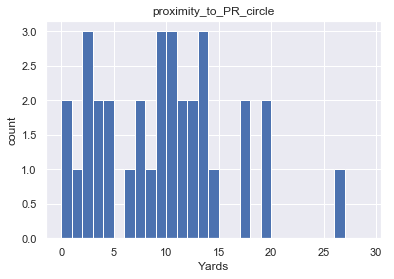

count    33.000000
mean      9.698254
std       6.167227
min       0.094337
25%       4.007398
50%       9.930081
75%      13.466461
max      26.229712
Name: proximity_to_PR_circle, dtype: float64


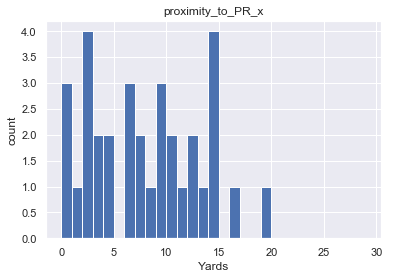

count    33.000000
mean      8.069091
std       5.215547
min       0.049995
25%       3.470001
50%       7.920002
75%      12.329998
max      19.600002
Name: proximity_to_PR_x, dtype: float64


In [31]:
proximity_distribution(new_ids, 'proximity_to_PR_circle')
proximity_distribution(new_ids, 'proximity_to_PR_x')

In [46]:
new_ids

,GameKey,PlayID,count,proximity_to_PR_circle,proximity_to_PR_x
0,5,3129,22,17.316649,16.419998
1,29,538,22,4.798677,4.279999
2,45,1212,22,3.713031,2.790001
3,54,1045,22,10.337241,10.309998
4,144,2342,22,12.411482,7.680000
5,149,3663,22,12.611556,12.329998
6,189,3509,22,2.440738,2.040001
7,218,3468,22,9.666671,9.440002
8,231,1976,22,10.518496,9.419998
9,280,3746,23,11.792108,3.470001


In [34]:
# Number of concussion plays affected by a rule with 8 yard restricted zone for PR by yardline distance
print(new_ids[new_ids['proximity_to_PR_x'] <= 8].shape[0])

# Number of concussion plays affected by a rule with 10 yard restricted zone for PR by euclidean distance to PR
print(new_ids[new_ids['proximity_to_PR_circle'] <= 8].shape[0])

17
13


- We can see on average **concussions are occurring on plays where a punt team player is within 8.1 yards in the x-direction from the PR or 9.7 yards in euclidean distance from the PR at the time the ball has landed after the punt.**
- Obviously this isn't a normal distribution, but we can see that more than half of concussions are occuring with a yardline distance less than 8 yards (17 of 33) or less than 10 yards euclidean distance (17 or 33) when this type of feature is present during the punt play.
    - THESE TWO MARKERS ARE REASONABLE FOR HAVING A PR RESTRICTED ZONE
    - **LINK APPROPRIATE NOTEBOOK ON PUNT RETURNS AND FAIR CATCHES**




- As a result of this as well
    - Based off this feature as well as data pertaining 
    - I believe this restricted zone could have helped to prevent these concussions, by forcing players to slow their pursuit of the PR and be more aware of their positioning relative to the PR.
- I also must note that many of the concussions could have potentially been prevented by the implementation of the new 'use of helmet' rule. You may have noticed I had one-hot encoded the concussion plays where I believe the 'use of helmet' rule could have changed the behavior of the player invovled in the concussion.
    - https://operations.nfl.com/the-rules/2018-rules-changes-and-points-of-emphasis/
    - https://operations.nfl.com/the-rules/nfl-video-rulebook/use-of-the-helmet/
- The below script is to just find where the PR restricted zone and helmet rule would have overlapped to understand the 'coverage' of these rules for the concussions involved in this dataset.




- Objective: Increase more punt returns while hopefully reducing number of concussions
	- Rule: PR Restricted Zone, removal of fair catch
	- Impact: Increase of 1637 punts being returnable, reduction of 876 returned punts due to new penalty
	- Result: Net gain of 761 more punt returns
		- New count of interesting plays: 3741 -> 56.0% of plays
		- Previous count of interesting plays: 2980 -> 44.6% of plays

- Objective: Reduce number of punt returns to reduce number of concussions
	- Rule: PR Restricted Zone
	- Impact: Reduction of 876 punt returns due to new penalty
	- Result: Net loss of 876 punt returns
		- New count of interesting plays: 2104 -> 31.5% of plays
		- Previous count of interesting plays: 2980 -> 44.6% of plays

- Would prefer rule change one vs rule change two, likely solution would be to use rule change two and see how many fair catches are called during the preseason. If the number is extremely low because the punt return is now more viable, than the fair catch could be removed.
- This rule would likely increase the number of tackling events, but combined with the new ‘use of helmet’ rule that number of injuries/concussion could go down

In [ ]:
# Get Number of concussions that may be affected by the use-of-helmet rule
print('Count of use-of-helmet rule:', injury_play[injury_play['helmet_rule'] == 1].shape[0])

# Combine with injury_play data to get one-hot encoding labels
combo = pd.merge(new_ids, injury_play,
                 how="inner",
                 on=['GameKey', 'PlayID'])

# Get Number of Concussions where the new 'use of helmet' rule and PR restricted zone overlap
where_condition = ((combo['proximity_to_PR_x'] <= 8) &
                   (combo['helmet_rule'] == 1))

print('Count for PR Restricted Zone and use-of-helmet rule:', combo[where_condition].shape[0])

- Total concussions occuring after the punt: 33
- Plays affected by PR Restricted Zone: 17
- Plays affected by use-of-helmet rule: 19
- Plays affected by both PR Restricted Zone and use-of-helmet rule: 11
    - Plays exclusively affected by PR Restricted Zone: 6
    - Plays exclusively affected by use-of-helmet rule: 9
- These two rules cover <b>26 of 33</b> plays where concussions occur after the punt

# RULE CHANGE PROPOSAL
1. **Restricted zone for PR during play.**
    - Return and punt team players may not be within 8 yards of the PR (by yardline distance) during a punt play unless the PR has signaled for a fair catch, the ball has been caught/muffed by the PR, or the ball has hit the ground.
    - **Penalty**: 10 yards from the PR and the play is called dead when infraction occurs.
    - The fair catch rule could also be removed similar to CFL punt return rules, to increase the number of returns, but its frequency of use given the proposed rule in a future season would give you a better idea if it should exist or not. Also, considering the reduction in number of concussions for kickoffs may be 
2. **Provide defenseless player protection to punt team players within 5 yards of PR.**
3. **Review plays where an apparent injury occurs and enforce any illegal blocking penalties** (blindside blocks, illegal block above the waist, etc.).